### Data Exploration


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%precision 4

C:\Users\wongs\Anaconda3\envs\myenv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\wongs\Anaconda3\envs\myenv\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\wongs\Anaconda3\envs\myenv\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


'%.4f'

In [2]:
df = pd.read_excel('../data/Dataset_5.xlsx', header=0, na_values='NA')

In [3]:
df.head(2)

,ESN,PassFail,Vibration,A1,A2,B1,B2,C1,C3,D1,D3,Ax,Ay,Bx,By,Ex,Ey,Fx,Fy
0,1,Reject,0.49,15.0,15.0,11.0,2.0,20,172.0,116,3.0,32,57,207,339,74,79,176,60
1,2,Pass,0.17,23.0,39.0,27.0,12.0,6,339.0,116,3.0,143,104,342,357,121,131,153,290


The dataset. 'ESN' is engine serial number. Output is 'PassFail' and 'Vibration'.Input is the rest of columns which are the measurement from the modular build.

In [4]:
#The engine serial number
#df=df.drop(labels='ESN',axis=1)

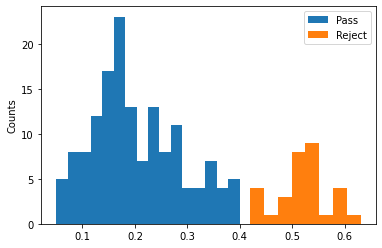

In [5]:
#Explore the distrinution of Vibration data
df_passfail=df[['PassFail','Vibration']]
df_fail_vibration=df['Vibration'][df.PassFail=='Reject']
df_pass_vibration=df['Vibration'][df.PassFail=='Pass']

plt.hist(df_pass_vibration, bins=16, label="Pass")
plt.hist(df_fail_vibration, bins=8, label="Reject")
plt.legend()
plt.ylabel("Counts");
# Despite small data set, the distribution about similar in shape for both 'Pass' and 'Reject'.

In [6]:
df_vibration=df[['PassFail','Vibration']]
df_vibration.groupby('PassFail').describe()

Vibration                                                    
             count      mean       std   min    25%   50%    75%   max
PassFail                                                              
Pass         149.0  0.203020  0.084787  0.05  0.140  0.19  0.260  0.40
Reject        31.0  0.519032  0.052240  0.42  0.495  0.52  0.545  0.63

Mean and median is relatively close. The ratio of std of both groups not more than 2.
It is kind of 2 distinct groups. <br>
Why is not a big normal distribution curve that cut off at the upper end for the "Reject"?

In view of the small dataset the distribution of the Vabration is near to normal. 

In [7]:
#df_seaborn=df.drop(labels='ESN',axis=1) #remove the engine serial number for plotting

In [8]:
# Scatter Plot Matrix
#colors = np.where(df["PassFail"]=='Reject','r','g')
#pd.plotting.scatter_matrix(df, figsize=(15,15), color=colors);

In [9]:
#df.corr()

The correlation of the all measurament parameter to Vibration rather weak.

Only the A1, A1, B2, C1 and Fx show mild linear correlation to Vibration. Fx is the unbalance of turbine disc, is correctly more sensitive as the the turbine disc locate furthest from hard coupling, similar to highest floor of 'Pisa Tower'.

D1 is the ball bearing of hard coupling side, which serve as base of 'Pisa Tower', the low correlation shown correctly as this is not the cause of the vibration from vibration analysis.

While the C3, D3, Ay, By, D3, Ey and Fy are angular angle in scale of 360 degree, as the rotor and turbine is rotating the angular direct shall not contribure direct to the Vibration.

** C1 is eccentricity measurement at the hightest point for HPS. The C1 low linear correlation is not explainable, which C1 has the most build rejects based on the drawing specification.

### Finding useful Features

In this section, we whittle down the number of features we have in the dataset.

In [117]:
from sklearn.feature_selection import SelectKBest,chi2,mutual_info_regression,mutual_info_classif

In [118]:
df_KBest= df[['A1','A2','B1','B2','C1','D1','Ax','Bx','Ex','Fx']]
y=df['Vibration']

In [119]:
y_cat=df['PassFail'].map({'Reject':1, 'Pass':0})

In [120]:
# For 'Pass Fail' categorical
from sklearn.model_selection import train_test_split
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(df_KBest, y_cat, test_size=0.2, random_state = 42)
skb = SelectKBest(mutual_info_regression, k=8)
skb.fit(X_train_cat, y_train_cat)

SelectKBest(k=8,
            score_func=<function mutual_info_regression at 0x00000235E9502CA0>)

In [121]:
skb.fit(X_train_cat, y_train_cat)

SelectKBest(k=8,
            score_func=<function mutual_info_regression at 0x00000235E9502CA0>)

In [122]:
skb.scores_.round(4)

array([0.0624, 0.0304, 0.    , 0.1202, 0.0623, 0.    , 0.0213, 0.    ,
       0.0143, 0.0785])

In [126]:
X_train_cat.columns[np.where(skb.scores_ > 0.03)]

Index(['A1', 'A2', 'B2', 'C1', 'Fx'], dtype='object')

### Prepare Data for Machine Learning
To reduce the noise, only the A1, A1, B2, C1 and Fx higher linear correlation shall be used.

In [17]:
X_cat= df[['A1', 'A2','B2','C1', 'Fx']]
X_cat.head()

,A1,A2,B2,C1,Fx
0,15.0,15.0,2.0,20,176
1,23.0,39.0,12.0,6,153
2,12.0,17.0,12.0,19,325
3,7.0,6.0,16.0,19,134
4,7.0,6.0,16.0,12,335


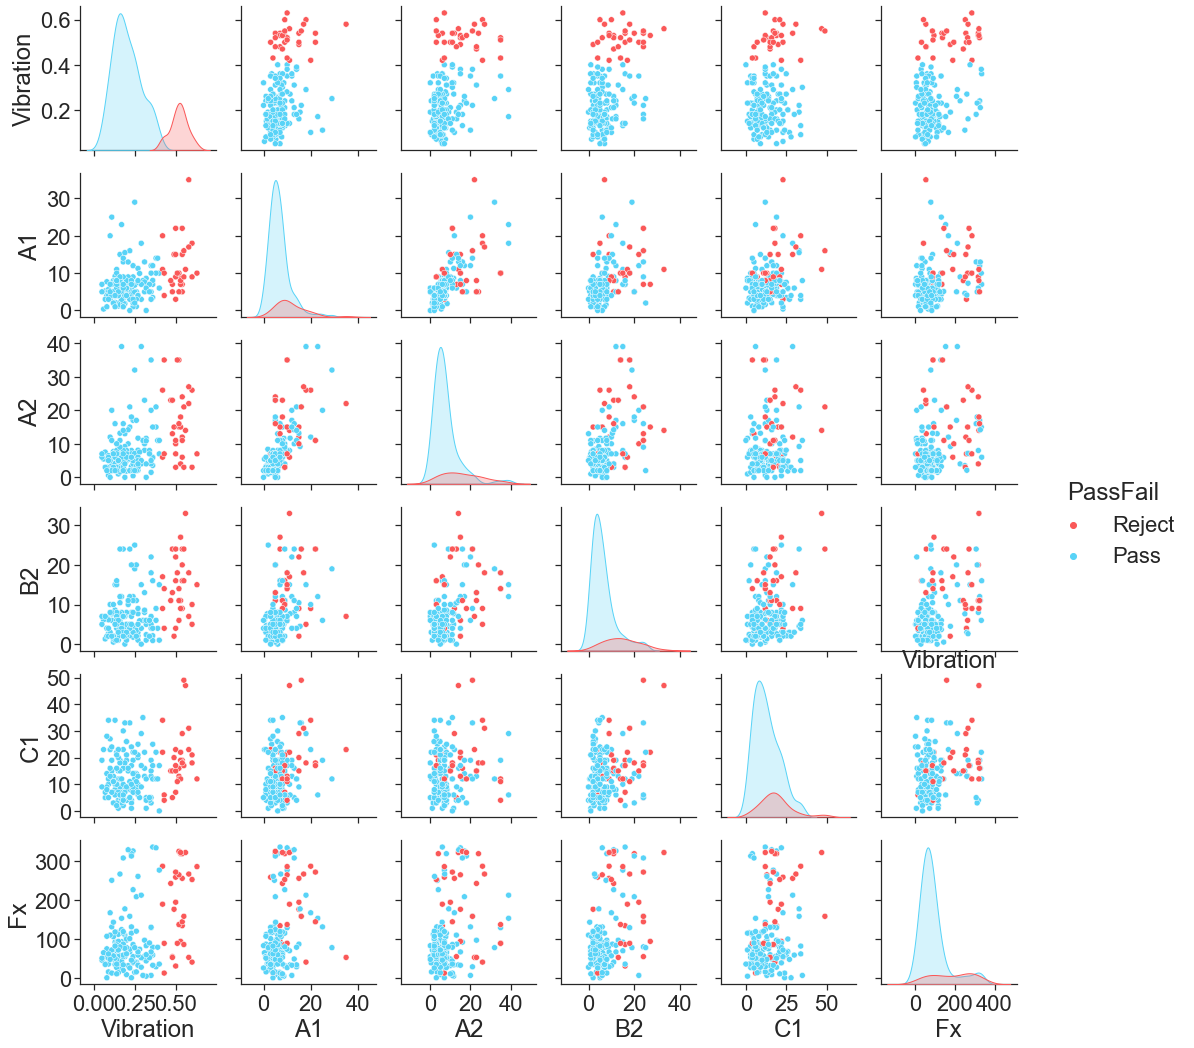

In [18]:
df_seaborn= df[['PassFail','Vibration','A1', 'A2', 'B2','C1',  'Fx']]
sb.set(style="ticks", font_scale=2)
pal = ["#FA5858", "#58D3F7"]
sb.pairplot(df_seaborn, hue="PassFail", palette=pal)
plt.title("Vibration");
sb.set(font_scale=1) #reset font size to 1

### Preprocessing

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_predict, cross_val_score  # For K-Fold Cross Validation

In [20]:
from sklearn.model_selection import train_test_split
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.2, random_state = 42)

In [21]:
#Normalised the features data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train_cat)
X_test_scaled = sc.transform(X_test_cat)
X_cat_scaled=sc.transform(X_cat)

In [22]:
#pd.DataFrame(X_train_scaled).head(2)

### Evaluating Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

LR_classifier = LogisticRegression(penalty='l2', C=1) # Best Parameter from GridSearch
LR_classifier.fit(X_train_scaled, y_train_cat)

LogisticRegression(C=1)

In [24]:
y_predict_train = LR_classifier.predict(X_train_scaled)
y_predict = LR_classifier.predict(X_test_scaled)
cm = confusion_matrix(y_test_cat, y_predict)
print(cm)

[[30  1]
 [ 4  1]]


In [25]:
# Training set
print(classification_report(y_train_cat, y_predict_train))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       118
           1       0.53      0.35      0.42        26

    accuracy                           0.83       144
   macro avg       0.70      0.64      0.66       144
weighted avg       0.81      0.83      0.81       144



In [26]:
#Test set
print(classification_report(y_test_cat, y_predict))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92        31
           1       0.50      0.20      0.29         5

    accuracy                           0.86        36
   macro avg       0.69      0.58      0.60        36
weighted avg       0.83      0.86      0.83        36



In [27]:
#Cross validation for consistence scores
LR_cv_score = np.mean(cross_val_score(LR_classifier, X_cat_scaled, y_cat, cv=5, n_jobs=4, scoring='accuracy'))
print("CV accuracy score for LR_classifier Model: ", LR_cv_score.round(2))
LR_cv_score = np.mean(cross_val_score(LR_classifier, X_cat_scaled, y_cat, cv=5, n_jobs=4, scoring='f1'))
print("CV f1 score for LR_classifier Model: ", LR_cv_score.round(2))

CV accuracy score for LR_classifier Model:  0.81
CV f1 score for LR_classifier Model:  0.37


In [28]:
#Benchmarking of 149 Pass vs 31 Reject #predicting Pass/Fail = "Pass"=149/180
1 - y_cat.mean()

0.8277777777777777

In [127]:
y_blind=np.zeros_like(y_train_cat)
print(classification_report(y_train_cat, y_blind)) #predicting Pass on train set = 82%

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       118
           1       0.00      0.00      0.00        26

    accuracy                           0.82       144
   macro avg       0.41      0.50      0.45       144
weighted avg       0.67      0.82      0.74       144



C:\Users\wongs\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [128]:
#y_blind=np.ones_like(y_train_cat)
#print(classification_report(y_train_cat, y_blind)) ##predicting Reject on train set 

### Predicting the model

In [31]:
# Measurement data input:
A1=20   #<20
A2=20   #<20
B2=20   #<30
C1=10   #<25
Fx=150  #<250

measurement = pd.DataFrame({'A1': [A1],'A2': [A2],'B2': [B2],'C1': [C1],'Fx': [Fx]})
measurement = sc.transform(measurement)

#perdict the Vibration of the measurements
prediction=pd.DataFrame(LR_classifier.predict(measurement))
#print(prediction)
result=prediction[0].map({0:'Pass', 1:'Reject'});
print(f'The Vibration predicted by LR_classifier is: {result[0]}')

The Vibration predicted by LR_classifier is: Reject


### Gridsearch the best parameter

In [32]:
from sklearn.model_selection import GridSearchCV
#C= np.logspace(0, 4, 20)
#penalty=['l1', 'l2', 'elasticnet']
param_grid = { 'C': np.logspace(0, 4, 10),'penalty':['l1', 'l2', 'elasticnet', 'none']} 
grid = GridSearchCV(LogisticRegression(),param_grid,scoring='f1', cv=5,refit=True,verbose=2, n_jobs=4)

In [33]:
grid.fit(X_train_scaled,y_train_cat)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=4,
             param_grid={'C': array([1.0000e+00, 2.7826e+00, 7.7426e+00, 2.1544e+01, 5.9948e+01,
       1.6681e+02, 4.6416e+02, 1.2915e+03, 3.5938e+03, 1.0000e+04]),
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             scoring='f1', verbose=2)

In [34]:
grid.best_params_

{'C': 1.0, 'penalty': 'l2'}

In [35]:
df_grid=pd.DataFrame(grid.cv_results_)

In [36]:
df_grid.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.0004,0.00049,0.0,0.0,1,l1,"{'C': 1.0, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,40


In [37]:
#Validation Curve of "C"
from sklearn.model_selection import validation_curve
train_scores, cv_scores = validation_curve(LogisticRegression(), X_train_scaled, y_train_cat, 
                                           param_name='C', cv=6, n_jobs=4,
                                           param_range=param_grid['C'], scoring='f1', verbose=2)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  60 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    0.0s finished


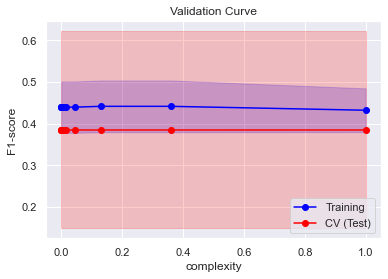

In [38]:
train_means = np.mean(train_scores, axis=1)
train_sd = np.std(train_scores, axis=1)

complexity=np.divide(1,param_grid['C'])

cv_means = np.mean(cv_scores, axis=1)
cv_sd = np.std(cv_scores, axis=1)

plt.plot(complexity, train_means, 'o-', label='Training', color='blue')
plt.fill_between(complexity, train_means-train_sd, train_means+train_sd, color='blue', alpha=0.2)

plt.plot(complexity, cv_means, 'o-', label='CV (Test)', color='red')
plt.fill_between(complexity, cv_means-cv_sd, cv_means+cv_sd, color='red', alpha=0.2)

plt.legend(loc='lower right');plt.ylabel('F1-score');plt.xlabel('complexity');plt.title('Validation Curve');

In [55]:
#ROC and AUC
LR_classifier_2 = LogisticRegression(C=1.0, penalty='l2')
LR_classifier_2.fit(X_train_scaled, y_train_cat)

In [40]:
y_test_probs=LR_classifier_2.predict_proba(X_test_scaled)

In [41]:
y_test_pred =LR_classifier_2.predict(X_test_scaled)

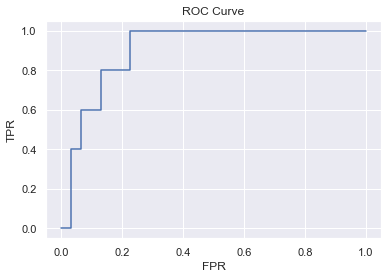

In [42]:
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, auc, f1_score,precision_recall_curve
from sklearn.metrics import matthews_corrcoef

fpr, tpr, thresholds = roc_curve(y_test_cat, y_test_probs[:, 1])
plt.plot(fpr, tpr,'b-');
plt.title('ROC Curve')
plt.xlabel('FPR');plt.ylabel('TPR');

In [43]:
print(f'The area under the AUC is {auc(fpr, tpr):.3f}.')

The area under the AUC is 0.903.


In [44]:
nn_precision, nn_recall, thresholds = precision_recall_curve(y_test_cat, y_test_probs[:, 1])

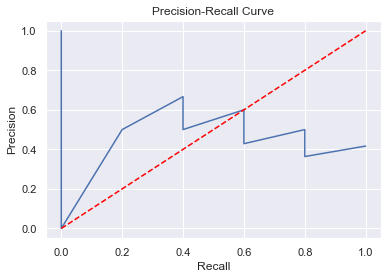

In [45]:
plt.plot(nn_recall, nn_precision,'b-');
plt.title('Precision-Recall Curve')
plt.xlabel('Recall');plt.ylabel('Precision');
plt.plot([0.0, 1.0], [0.0, 1.0], color='red', linestyle="--");

## Visualising the Training set results

### Predicting the model

In [46]:
# Measurement data input:
A1=25   #<25
A2=25   #<25
B2=25   #<25
C1=10   #<25
Fx=350  #<250

measurement = pd.DataFrame({'A1': [A1],'A2': [A2],'B2': [B2],'C1': [C1],'Fx': [Fx]})
measurement = sc.transform(measurement)

#perdict the Vibration of the measurements
prediction=pd.DataFrame(LR_classifier.predict(measurement))
#print(prediction)
result=prediction[0].map({0:'Pass', 1:'Reject'});
print(f'The Vibration predicted by Logistic Regression classifier is: {result[0]}')

The Vibration predicted by Logistic Regression classifier is: Reject


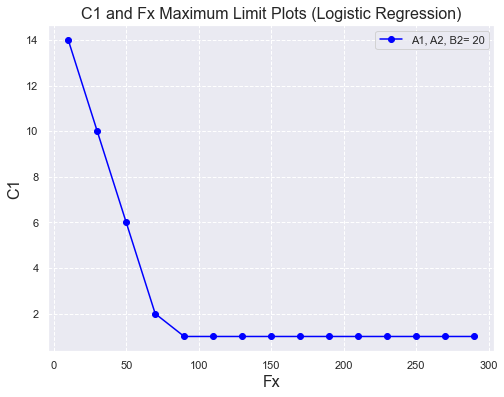

In [47]:
# Measurement data input from Compressor
A1=20   #<25
A2=20   #<25
B2=20   #<25

# Find the limit of the C1 and Fx on the matching Turbine
C1_list=[]
Fx_list=[]
C1_range=np.arange(1,50,1)
Fx_range=np.arange(10,300,20)
for i in Fx_range:
    for j in C1_range:
        measurement = pd.DataFrame({'A1': [A1],'A2': [A2],'B2': [B2],'C1': [j],'Fx': [i]})
        measurement = sc.transform(measurement)
        prediction=LR_classifier.predict(measurement)
        if prediction>0 :
            break
    C1_list.append(j)
    Fx_list.append(i)

# C1 and Fx predict tramline
plt.figure(figsize=(8,6))
plt.plot(Fx_list,C1_list,'o-',label='A1, A2, B2= 20', color='blue')
plt.grid(linestyle='--')
plt.xlabel('Fx',fontsize=16)
plt.ylabel('C1',fontsize=16)
plt.legend()
plt.title('C1 and Fx Maximum Limit Plots (Logistic Regression)',fontsize=16);

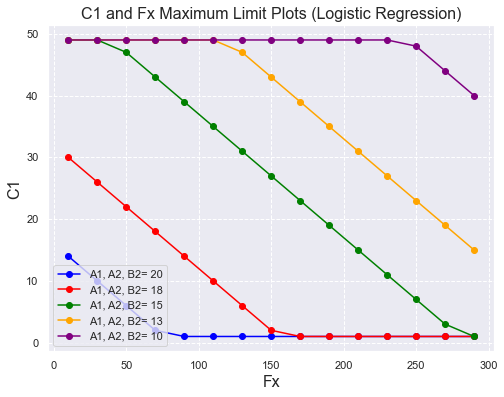

In [48]:
# Measurement data input from Compressor
A1=20   #<25
A2=20   #<25
B2=20   #<25

# Find the limit of the C1 and Fx on the matching Turbine
C1_list=[]
Fx_list=[]
C1_range=np.arange(1,50,1)
Fx_range=np.arange(10,300,20)
for i in Fx_range:
    for j in C1_range:
        measurement = pd.DataFrame({'A1': [A1],'A2': [A2],'B2': [B2],'C1': [j],'Fx': [i]})
        measurement = sc.transform(measurement)
        prediction=LR_classifier.predict(measurement)
        if prediction>0 :
            break
    C1_list.append(j)
    Fx_list.append(i)
    
C1_list2=[]
Fx_list2=[]
C1_range=np.arange(1,50,1)
Fx_range=np.arange(10,300,20)
for i in Fx_range:
    for j in C1_range:
        measurement = pd.DataFrame({'A1': [A1-2],'A2': [A2-2],'B2': [B2-2],'C1': [j],'Fx': [i]})
        measurement = sc.transform(measurement)
        prediction=LR_classifier.predict(measurement)
        if prediction>0 :
            break
    C1_list2.append(j)
    Fx_list2.append(i)
    
C1_list3=[]
Fx_list3=[]
C1_range=np.arange(1,50,1)
Fx_range=np.arange(10,300,20)
for i in Fx_range:
    for j in C1_range:
        measurement = pd.DataFrame({'A1': [A1-5],'A2': [A2-5],'B2': [B2-5],'C1': [j],'Fx': [i]})
        measurement = sc.transform(measurement)
        prediction=LR_classifier.predict(measurement)
        if prediction>0 :
            break
    C1_list3.append(j)
    Fx_list3.append(i)

C1_list4=[]
Fx_list4=[]
C1_range=np.arange(1,50,1)
Fx_range=np.arange(10,300,20)
for i in Fx_range:
    for j in C1_range:
        measurement = pd.DataFrame({'A1': [A1-7],'A2': [A2-7],'B2': [B2-7],'C1': [j],'Fx': [i]})
        measurement = sc.transform(measurement)
        prediction=LR_classifier.predict(measurement)
        if prediction>0 :
            break
    C1_list4.append(j)
    Fx_list4.append(i)
    
C1_list5=[]
Fx_list5=[]
C1_range=np.arange(1,50,1)
Fx_range=np.arange(10,300,20)
for i in Fx_range:
    for j in C1_range:
        measurement = pd.DataFrame({'A1': [A1-10],'A2': [A2-10],'B2': [B2-10],'C1': [j],'Fx': [i]})
        measurement = sc.transform(measurement)
        prediction=LR_classifier.predict(measurement)
        if prediction>0 :
            break
    C1_list5.append(j)
    Fx_list5.append(i)
    
# C1 and Fx predict tramline
plt.figure(figsize=(8,6))
plt.plot(Fx_list,C1_list,'o-',label='A1, A2, B2= 20', color='blue')
plt.plot(Fx_list2,C1_list2,'o-',label='A1, A2, B2= 18', color='red')
plt.plot(Fx_list3,C1_list3,'o-',label='A1, A2, B2= 15', color='green')
plt.plot(Fx_list4,C1_list4,'o-',label='A1, A2, B2= 13', color='orange')
plt.plot(Fx_list5,C1_list5,'o-',label='A1, A2, B2= 10', color='purple')
plt.grid(linestyle='--')
plt.xlabel('Fx',fontsize=16)
plt.ylabel('C1',fontsize=16)
plt.legend()
plt.title('C1 and Fx Maximum Limit Plots (Logistic Regression)',fontsize=16);

### Explore the Logistic Regression Coeficients

In [57]:
LR_classifier.coef_

array([[0.4083, 0.1996, 0.7709, 0.2371, 0.4536]])

In [58]:
LR_classifier.intercept_

array([-2.1048])

In [62]:
# create a coefficient table
features= X_cat.columns.values
summary_table = pd.DataFrame (columns=['Feature name'], data = features)
summary_table['Coefficient'] = np.transpose(LR_classifier.coef_) # add the coefficient 
summary_table.index = summary_table.index + 1 # add the intercept at index 0
summary_table.loc[0] = ['Intercept', LR_classifier.intercept_[0]] # add the intercept at index 0
summary_table = summary_table.sort_index() # sort the df by index
summary_table # display the summary table

,Feature name,Coefficient
0,Intercept,-2.104775
1,A1,0.408341
2,A2,0.199571
3,B2,0.770891
4,C1,0.237067
5,Fx,0.453616


Adding the Odd ratio

In [63]:
summary_table['Odds_ratio'] = np.exp(summary_table.Coefficient) #add Odd ratio to table
summary_table.sort_values('Odds_ratio', ascending=False)

,Feature name,Coefficient,Odds_ratio
3,B2,0.770891,2.161691
5,Fx,0.453616,1.573994
1,A1,0.408341,1.504320
4,C1,0.237067,1.267526
2,A2,0.199571,1.220878
0,Intercept,-2.104775,0.121873
